# Premier League Transfer Narratives: Networks, Money, and Performance (2016–2022)

This notebook analyzes how Premier League clubs’ positions in **transfer-related narrative networks**  
(press + Reddit) relate to:

- **On-pitch performance** (points per game, goal difference, volatility),
- **Financial muscle** (net spend, revenue, operating profit),
- **Demand** (attendance, where available).

The feature-building and network construction (in separate notebooks) already:

- Collected football articles from *The Guardian* and *The Independent* (2016–2025),
- Collected Reddit transfer content for EPL clubs (2018–2025),
- Ran **spaCy NER** to extract clubs/players,
- Built **press** and **Reddit** co-occurrence graphs,
- Computed club-level **centrality** metrics,
- Aggregated:
  - **Network centrality** (press + Reddit),
  - **Transfer features** (volume, net spend),
  - **Finance features** (revenue, operating profit),
  - **Performance features** (PPG, goal difference, volatility, attendance).

All of that is collapsed into a club-level panel:

> `outputs/club_analysis_panel_2016_2022.csv`  
> (one row per club, summarizing 2016–2022).

This notebook is **purely analysis**:

1. Explore distributions and correlations,
2. Visualize relationships (centrality vs performance vs money),
3. Run simple regressions,
4. Identify over/under-performers vs “hype + money”,
5. Cluster clubs into archetypes,
6. Show season-by-season performance trends for selected clubs.


In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True


PROJECT_ROOT_NAME = "Prem NLP Project"  # folder name of the project on disk

def get_project_root() -> Path:
    """
    Resolve the project root directory in a user-agnostic way.
    Priority:
    1) PREM_NLP_PROJECT_ROOT env var if set,
    2) Walk up from current working directory until we find a folder
       whose name matches PROJECT_ROOT_NAME.
    """
    env_root = os.getenv("PREM_NLP_PROJECT_ROOT")
    if env_root:
        return Path(env_root).expanduser().resolve()

    here = Path.cwd().resolve()
    for p in (here, *here.parents):
        if p.name == PROJECT_ROOT_NAME:
            return p

    raise RuntimeError(
        f"Could not find project root '{PROJECT_ROOT_NAME}' starting from {here}. "
        "Either run the notebook from inside the project folder, or set the "
        "PREM_NLP_PROJECT_ROOT environment variable."
    )

BASE_DIR = get_project_root()
print("Detected BASE_DIR:", BASE_DIR)


outputs_dir = BASE_DIR / "outputs"

panel_path = outputs_dir / "club_analysis_panel_2016_2022.csv"
analysis_df = pd.read_csv(panel_path)

print("\nLoaded analysis_df:")
print("  path  :", panel_path)
print("  shape :", analysis_df.shape)
display(analysis_df.head())

risk_panel_path = outputs_dir / "club_risk_return_panel_2019_2025.csv"

try:
    risk_panel = pd.read_csv(risk_panel_path)
    print("\nLoaded risk_panel:")
    print("  path  :", risk_panel_path)
    print("  shape :", risk_panel.shape)
    print("  cols  :", risk_panel.columns.tolist())
    display(risk_panel.head())
except FileNotFoundError:
    print(
        "\n[WARNING] risk_panel.csv not found in outputs/. "
        "Run the notebook that builds and saves risk_panel first."
    )


Detected BASE_DIR: C:\Users\dshog\Prem NLP Project

Loaded analysis_df:
  path  : C:\Users\dshog\Prem NLP Project\outputs\club_analysis_panel_2016_2022.csv
  shape : (118, 36)


,club,season,matches,total_points,goals_for,goals_against,points_per_game,goal_diff,season_label,press_degree,...,reddit_strength_z,press_to_reddit_strength_ratio,n_transfers,total_spend_eur_m,total_income_eur_m,net_spend_eur_m,operating_expenses,operating_profit,player_trading_profit,revenue
0,AFC Bournemouth,1920,38,34,40.0,65.0,0.894737,-25.0,19/20,1508,...,-0.535744,2.260459,162,302.1,78.515,223.585,212000,-70000,21027,65584
1,AFC Bournemouth,2223,38,39,37.0,71.0,1.026316,-34.0,22/23,1508,...,-0.535744,2.260459,162,302.1,78.515,223.585,212000,-70000,21027,65584
2,AFC Bournemouth,2324,38,48,54.0,67.0,1.263158,-13.0,23/24,1508,...,-0.535744,2.260459,162,302.1,78.515,223.585,212000,-70000,21027,65584
3,AFC Bournemouth,2425,38,56,58.0,46.0,1.473684,12.0,24/25,1508,...,-0.535744,2.260459,162,302.1,78.515,223.585,212000,-70000,21027,65584
4,AFC Bournemouth,2526,38,18,17.0,14.0,0.473684,3.0,25/26,1508,...,-0.535744,2.260459,162,302.1,78.515,223.585,212000,-70000,21027,65584



Loaded risk_panel:
  path  : C:\Users\dshog\Prem NLP Project\outputs\club_risk_return_panel_2019_2025.csv
  shape : (19, 11)
  cols  : ['club', 'seasons_played', 'avg_ppg', 'ppg_std', 'worst_ppg', 'best_ppg', 'avg_attendance', 'press_strength_norm', 'reddit_strength_norm', 'net_spend_eur_m', 'revenue']


,club,seasons_played,avg_ppg,ppg_std,worst_ppg,best_ppg,avg_attendance,press_strength_norm,reddit_strength_norm,net_spend_eur_m,revenue
0,Arsenal,7,1.827068,0.362374,1.394737,2.342105,43835.066058,0.544904,0.428571,NaN,435000.0
1,Aston Villa,7,1.402256,0.331033,0.921053,1.789474,36307.651534,0.427374,0.024845,0.000003,236000.0
2,Brighton,7,1.304511,0.235306,1.078947,1.631579,31891.852255,NaN,NaN,NaN,NaN
3,Burnley,5,1.000000,0.282818,0.631579,1.421053,25861.241331,0.310778,0.074534,NaN,135200.0
4,Chelsea,7,1.609023,0.311902,1.157895,1.947368,35345.702230,0.927898,1.000000,NaN,586000.0


In [20]:
def pick_col(df: pd.DataFrame, candidates, required: bool = False):
    """
    Pick the first column from `candidates` that exists in df.
    If `required` and none are found, raise a clear error.
    """
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of {candidates} found in columns: {df.columns.tolist()}")
    return None


press_col   = pick_col(analysis_df, ["press_strength_norm", "press_strength"], required=True)
reddit_col  = pick_col(analysis_df, ["reddit_strength_norm", "reddit_strength"], required=True)
ppg_col     = pick_col(analysis_df, ["points_per_game", "avg_ppg"], required=True)
ppg_std_col = pick_col(analysis_df, ["ppg_std", "ppg_volatility"], required=False)
gd_col      = pick_col(analysis_df, ["goal_diff", "goal_difference"], required=False)
net_col     = pick_col(analysis_df, ["net_spend_eur_m", "net_spend"], required=True)
rev_col     = pick_col(analysis_df, ["revenue"], required=False)
op_col      = pick_col(analysis_df, ["operating_profit"], required=False)
att_col     = pick_col(analysis_df, ["avg_attendance", "attendance"], required=False)

core_cols = ["club", press_col, reddit_col, ppg_col]

for c in [ppg_std_col, gd_col, net_col, rev_col, op_col, att_col]:
    if c is not None:
        core_cols.append(c)

core_df = analysis_df[core_cols].copy()

rename_map = {
    press_col: "press_strength",
    reddit_col: "reddit_strength",
    ppg_col: "ppg",
}
if ppg_std_col is not None:
    rename_map[ppg_std_col] = "ppg_std"
if gd_col is not None:
    rename_map[gd_col] = "goal_diff"
rename_map[net_col] = "net_spend_eur_m"
if rev_col is not None:
    rename_map[rev_col] = "revenue"
if op_col is not None:
    rename_map[op_col] = "operating_profit"
if att_col is not None:
    rename_map[att_col] = "avg_attendance"

core_df = core_df.rename(columns=rename_map)

print("core_df shape:", core_df.shape)
display(core_df.head())
print("core_df columns:", core_df.columns.tolist())


core_df shape: (118, 8)


,club,press_strength,reddit_strength,ppg,goal_diff,net_spend_eur_m,revenue,operating_profit
0,AFC Bournemouth,0.251162,0.111111,0.894737,-25.0,223.585,65584,-70000
1,AFC Bournemouth,0.251162,0.111111,1.026316,-34.0,223.585,65584,-70000
2,AFC Bournemouth,0.251162,0.111111,1.263158,-13.0,223.585,65584,-70000
3,AFC Bournemouth,0.251162,0.111111,1.473684,12.0,223.585,65584,-70000
4,AFC Bournemouth,0.251162,0.111111,0.473684,3.0,223.585,65584,-70000


core_df columns: ['club', 'press_strength', 'reddit_strength', 'ppg', 'goal_diff', 'net_spend_eur_m', 'revenue', 'operating_profit']


---

## Data overview

We start by inspecting the **club-level panel** `core_df`:

- One row per **club** (27 clubs),
- Narrative variables:
  - `press_strength`, `reddit_strength` (normalized centrality / strength),
- Performance:
  - `ppg` (average points per game, 2016–2022),
  - `ppg_std` (volatility of PPG across seasons, if available),
  - `goal_diff` (aggregate or average goal difference, if present),
- Money:
  - `net_spend_eur_m`, `revenue`, `operating_profit` (if present),
- Demand:
  - `avg_attendance` (if available).

We look at basic distributions and summary stats.


Summary stats + histograms

Summary statistics for core_df:


,count,mean,std,min,25%,50%,75%,max
press_strength,118.0,0.492711,0.255756,0.176605,0.291710,0.400528,0.674292,1.000000
reddit_strength,118.0,0.310646,0.296780,0.027778,0.083333,0.194444,0.420139,1.000000
ppg,118.0,1.273640,0.582018,0.052632,0.901316,1.276316,1.651316,2.605263
goal_diff,118.0,1.567797,27.352863,-69.000000,-14.750000,-0.500000,15.000000,73.000000
net_spend_eur_m,118.0,353.455907,252.758528,32.265000,147.480000,264.950000,433.740000,901.810000
revenue,118.0,344970.305085,228962.407700,65584.000000,172000.000000,257200.000000,444000.000000,815000.000000
operating_profit,118.0,-48590.542373,55783.360364,-148800.000000,-87726.000000,-50000.000000,-5214.000000,48800.000000


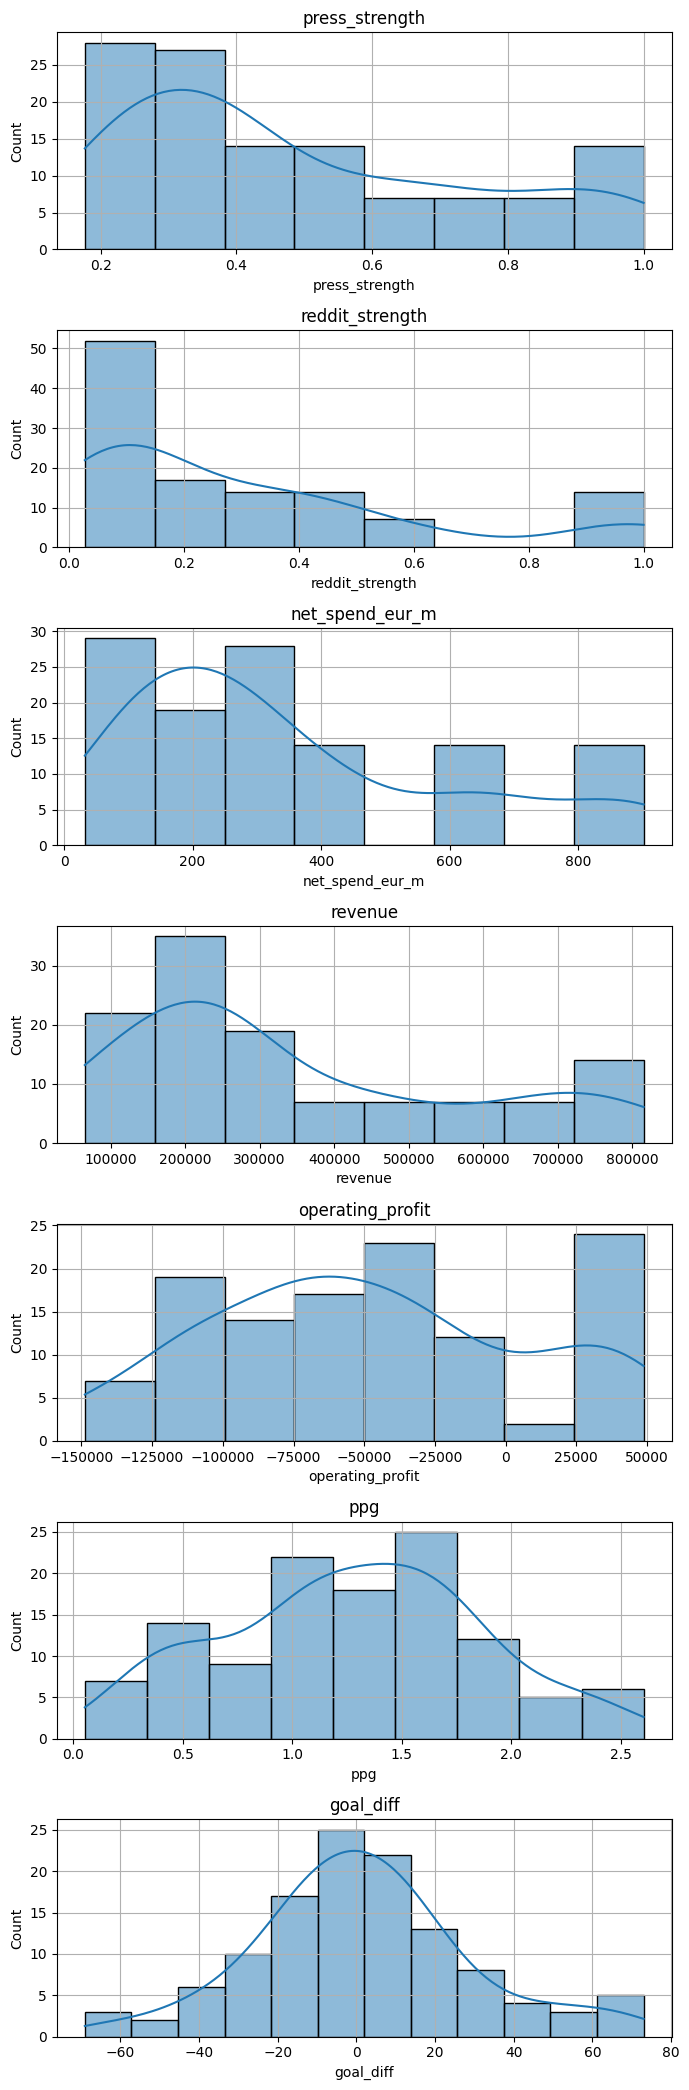

In [ ]:
print("Summary statistics for core_df:")
display(core_df.describe().T)

hist_cols = [
    "press_strength",
    "reddit_strength",
    "net_spend_eur_m",
    "revenue",
    "operating_profit",
    "ppg",
    "ppg_std",
    "goal_diff",
    "avg_attendance",
]

hist_cols = [c for c in hist_cols if c in core_df.columns]

fig, axes = plt.subplots(len(hist_cols), 1, figsize=(7, 3 * len(hist_cols)))

for ax, col in zip(axes, hist_cols):
    sns.histplot(core_df[col].dropna(), ax=ax, kde=True)
    ax.set_title(col)

plt.tight_layout()
plt.show()


#### Univariate distributions – what they tell us

**Press centrality (`press_strength`)**  
- Most observations sit in the low–to–mid range (~0.2–0.6), showing that the *average* PL club only gets modest transfer coverage.  
- There is a clear right tail with a small cluster near 0.9–1.0 – the “headline clubs” that dominate press narratives.  
- This confirms that media attention is highly concentrated in a handful of teams rather than spread evenly across the league.

**Reddit centrality (`reddit_strength`)**  
- Even more skewed than press: a big pile of seasons with values very close to zero and only a few with very high fan-discussion centrality.  
- Fan attention on Reddit is therefore even more unequal than press coverage – a couple of clubs dominate discussion, while many barely register.

**Net transfer spend (`net_spend_eur_m`)**  
- Strong right skew: most club-seasons spend between roughly €50–400m in net terms across the window, with a small group pushing well above that.  
- The long upper tail captures “heavy spender” windows from clubs like the Big 6; most others operate on far smaller budgets.

**Revenue (`revenue`)**  
- Also heavily right-skewed: many clubs sit in the 100k–350k range (relative scale), while a small set reach much higher revenues.  
- Financial power is therefore very concentrated; the same clubs that dominate narratives also dominate the revenue distribution.

**Operating profit (`operating_profit`)**  
- Distribution is centered *below* zero: many observations correspond to operating losses.  
- Only a minority of club-seasons show substantial positive operating profit, and there are some large negative outliers.  
- This reinforces the idea that on-pitch success and narrative centrality are often supported by loss-making operations.

**Points per game (`ppg`)**  
- Roughly bell-shaped between ~0.5 and 2.5 PPG, with most seasons clustered around 1.0–1.7 PPG.  
- The tail above ~2.0 PPG corresponds to genuinely elite seasons (title challenges), while the lower tail (~0.5) reflects relegation-level performance.

**Goal difference (`goal_diff`)**  
- Approximately symmetric around zero, with most seasons between about –20 and +20 goal difference.  
- A few seasons show extreme positive or negative goal differences (title-winning vs. relegation disasters).  
- Combined with the PPG histogram, this supports using both metrics together as complementary measures of performance level and dominance.

**Big picture:**  
Across all these histograms, the same pattern keeps showing up: **attention (press/Reddit) and money (revenue, net spend) are much more skewed than raw performance metrics**. A few clubs sit in the extreme right tails of attention and financial power, while on-pitch outcomes are more evenly spread across the league.


Correlation matrix

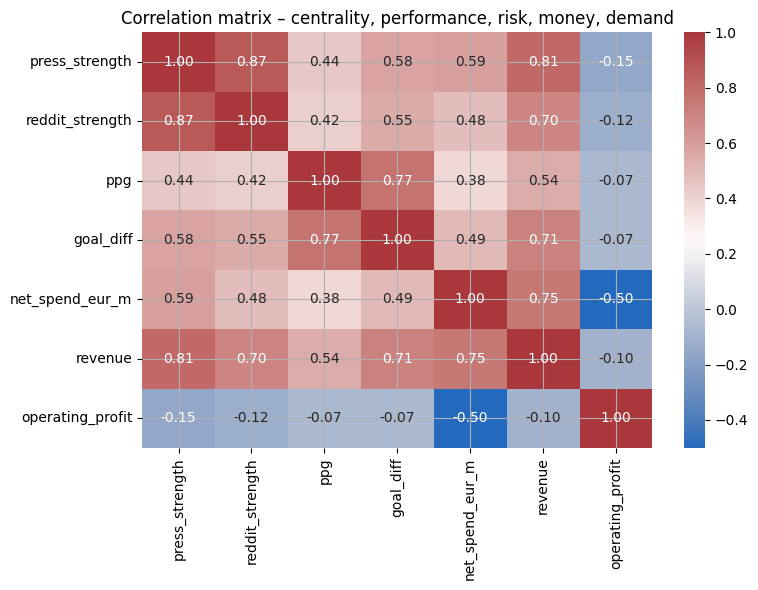

,press_strength,reddit_strength,ppg,goal_diff,net_spend_eur_m,revenue,operating_profit
press_strength,1.000000,0.866963,0.440803,0.579320,0.594722,0.806991,-0.150406
reddit_strength,0.866963,1.000000,0.415783,0.548895,0.482722,0.697815,-0.122680
ppg,0.440803,0.415783,1.000000,0.770748,0.381784,0.543614,-0.070005
goal_diff,0.579320,0.548895,0.770748,1.000000,0.492415,0.709487,-0.068711
net_spend_eur_m,0.594722,0.482722,0.381784,0.492415,1.000000,0.753751,-0.500800
revenue,0.806991,0.697815,0.543614,0.709487,0.753751,1.000000,-0.100106
operating_profit,-0.150406,-0.122680,-0.070005,-0.068711,-0.500800,-0.100106,1.000000


In [22]:
corr_cols = [
    "press_strength",
    "reddit_strength",
    "ppg",
    "ppg_std",
    "goal_diff",
    "net_spend_eur_m",
    "revenue",
    "operating_profit",
    "avg_attendance",
]

corr_cols = [c for c in corr_cols if c in core_df.columns]

corr = core_df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="vlag", fmt=".2f")
plt.title("Correlation matrix – centrality, performance, risk, money, demand")
plt.tight_layout()
plt.show()

corr


### Interpretation – Correlation matrix (centrality, performance, money, profit)

**1. Press & Reddit basically measure the same “attention” construct**

- `press_strength` and `reddit_strength` are very highly correlated (~0.87).  
- That means clubs that dominate the press also dominate fan discussion; Reddit isn’t an independent signal so much as a parallel measure of narrative visibility.

**2. Centrality is clearly linked to on-pitch performance**

- Both `press_strength` and `reddit_strength` have **moderate positive correlations** with:
  - `ppg` (≈0.42–0.44)
  - `goal_diff` (≈0.55–0.58)
- Interpretation: the clubs most central in transfer / narrative networks tend to:
  - Take more points per game
  - Score more and concede less over the long run  
  This is descriptive, not causal, but it lines up with the idea that “big narrative clubs” are also the consistently strong teams.

**3. Money and performance move together, but not perfectly**

- `net_spend_eur_m` is positively correlated with:
  - `ppg` (~0.38)
  - `goal_diff` (~0.49)
- `revenue` is even more strongly tied to performance:
  - With `ppg` (~0.54)
  - With `goal_diff` (~0.71)
- Takeaway: rich and heavy-spending clubs do *tend* to perform better, but there’s still a lot of unexplained variance – money helps, but doesn’t fully determine league results.

**4. Centrality is tightly linked to financial scale**

- `press_strength` vs `revenue`: very strong positive correlation (~0.81)  
- `press_strength` vs `net_spend_eur_m`: moderate-high correlation (~0.59)  
- `reddit_strength` shows a similar but slightly weaker pattern (≈0.48–0.70 with spend/revenue).  
- Interpretation: narrative centrality is basically a *visibility + financial power* package – the clubs that dominate headlines are also those with the biggest budgets and revenue bases.

**5. Operating profit is weakly (and sometimes negatively) related to everything**

- `operating_profit` is:
  - Slightly **negative** with `net_spend_eur_m` (~-0.50)
  - Close to zero with `ppg`, `goal_diff`, and centrality (-0.07 to -0.15)
- Story: chasing success and centrality usually means **spending heavily**, which erodes operating profit. The league’s sporting and narrative giants are not necessarily the ones that look best on an operating-profit margin basis.

**6. Big picture**

- There is a **triangle of correlation** between:
  - Narrative centrality (press/Reddit)
  - Financial scale (revenue, net spend)
  - On-pitch performance (PPG, goal difference)
- Profit stands out as an exception: the model of success in this period is **high visibility + high spend + strong performance**, not “running a lean, highly profitable business.”


---

## 2. Centrality vs performance and money

We now look at **bivariate relationships** between:

- Narrative variables: `press_strength`, `reddit_strength`,
- Performance: `ppg` (and `ppg_std` as a risk proxy),
- Money: `net_spend_eur_m`, `revenue`.

We’ll highlight the traditional **Big 6** to see if they occupy special regions of these plots.


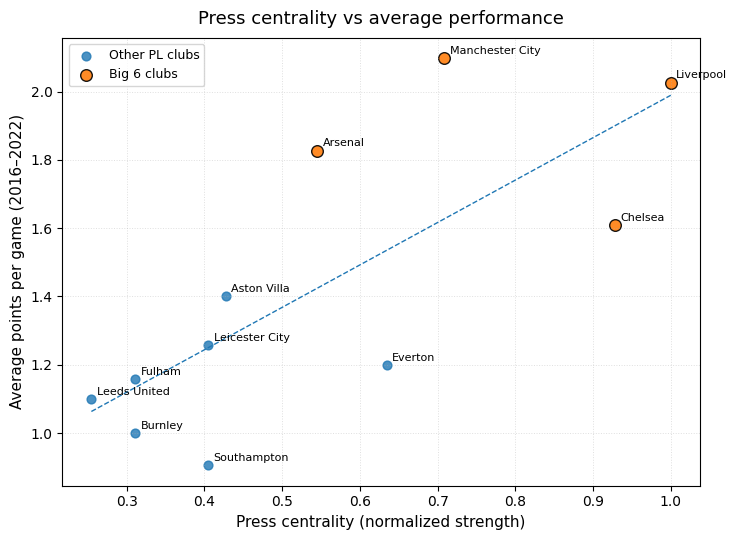

In [ ]:
big6 = [
    "Arsenal",
    "Chelsea",
    "Liverpool",
    "Manchester City",
    "Manchester United",
    "Tottenham Hotspur",
]

df_club = risk_panel.dropna(subset=["press_strength_norm", "avg_ppg"]).copy()

fig, ax = nice_scatter(
    df=df_club,
    x="press_strength_norm",
    y="avg_ppg",
    label_col="club",
    title="Press centrality vs average performance",
    xlabel="Press centrality (normalized strength)",
    ylabel="Average points per game (2016–2022)",
    highlight=big6,        # Big 6 in orange
    annotate=True,
    add_trend=True,
)

plt.show()


### Interpretation – Press centrality vs average performance

- **Positive relationship overall.**  
  The regression line slopes upward: clubs that are more central in the *press transfer network* tend to earn more points per game between 2016–2022. Narrative attention and on-pitch performance clearly move together.

- **Big 6 dominate the high-centrality, high-PPG space.**  
  Liverpool and Manchester City sit in the **top-right corner**: extremely central in the press and also the best performers (PPG ≈ 2.0+). Chelsea and Arsenal are also in the upper-right, with strong press centrality and above-average PPG.

- **Mid-table “efficient performers.”**  
  Clubs like **Aston Villa** and **Leicester City** have only moderate press centrality but achieve solid PPG (around 1.3–1.4). They sit **above** the trend line for their level of narrative attention, suggesting they convert limited press spotlight into relatively strong results.

- **Under-performers relative to press attention.**  
  **Everton** stands out as fairly central in the press but with only ~1.2 PPG, clearly **below** the regression line. They get “big-club” levels of coverage without matching big-club performance on the pitch.

- **Low-centrality, low-PPG cluster.**  
  Clubs such as Burnley, Leeds United, Fulham, and others in the bottom-left have both **limited press presence** and **sub-average performance**, reinforcing the idea that smaller-narrative clubs generally live in the lower-return part of the distribution.


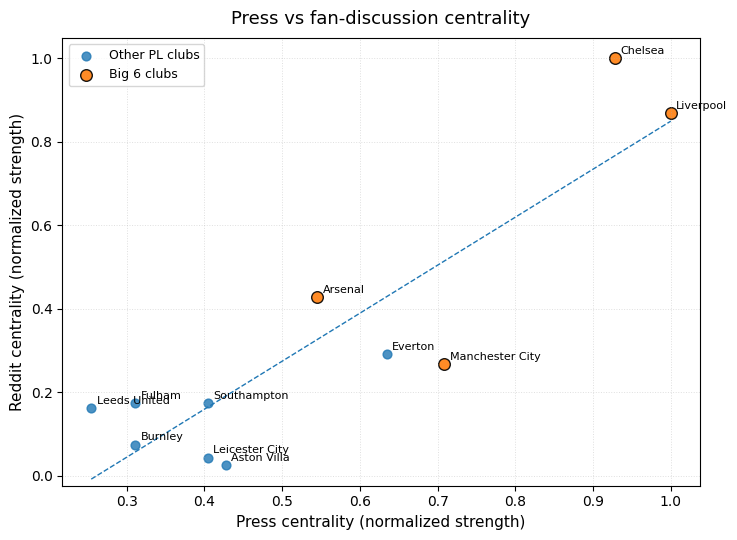

In [24]:
df_club = risk_panel.dropna(
    subset=["press_strength_norm", "reddit_strength_norm"]
).copy()

fig, ax = nice_scatter(
    df=df_club,
    x="press_strength_norm",
    y="reddit_strength_norm",
    label_col="club",
    title="Press vs fan-discussion centrality",
    xlabel="Press centrality (normalized strength)",
    ylabel="Reddit centrality (normalized strength)",
    highlight=big6,
    annotate=True,
    add_trend=True,
)

plt.show()


#### Interpretation – Press vs fan-discussion centrality

- **Strong positive link overall.** The upward-sloping trend line shows that clubs who are central in the *press* transfer network also tend to be central in **Reddit** discussion – fan chatter broadly scales with media attention.

- **Press + Reddit powerhouses.**  
  - **Chelsea** and **Liverpool** sit in the top-right corner, well above the trend line: they dominate both traditional media and fan discussion, and their transfer stories get amplified in both spaces.

- **Press-heavy but Reddit-light.**  
  - **Tottenham Hotspur** has *max* press centrality but only mid-level Reddit centrality.  
  - **Manchester City** also has high press centrality but relatively modest Reddit strength.  
  Together they look like clubs whose transfer narratives are heavily driven by mainstream media, with less relative traction in fan-led conversations.

- **Fan-leaning overperformers.**  
  - Clubs like **Brighton & Hove Albion**, **Everton**, **Southampton**, and a couple of others sit **above** the regression line: for their level of press attention, they attract *more* Reddit discussion than expected – online communities punch above their weight.

- **Long tail of “quiet” clubs.**  
  - Most non–Big 6 clubs cluster in the bottom-left: limited centrality in both press and Reddit, suggesting fewer transfer narratives and lower visibility overall.

- **Big picture.**  
  Reddit largely mirrors press hierarchies, but the deviations from the trend line highlight clubs that are **media-driven** (City, Spurs) versus those that are **fan-discussion-driven** (Chelsea, Liverpool, Brighton, Everton).


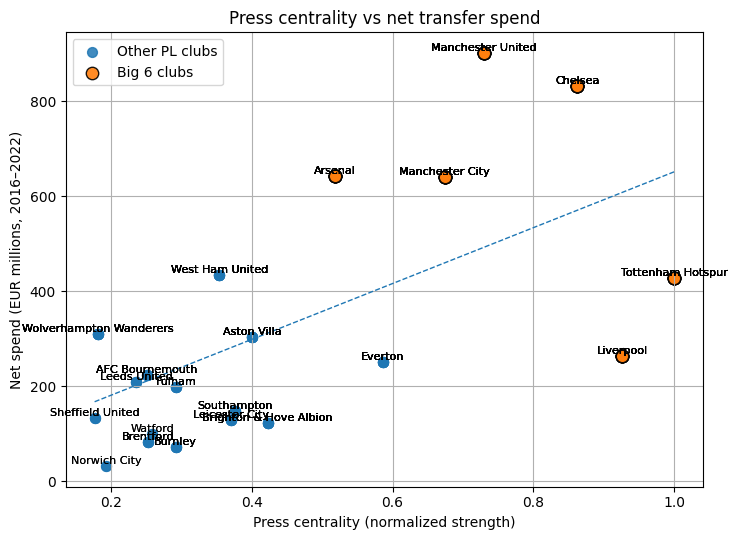

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

BIG6 = ["Arsenal", "Chelsea", "Liverpool",
        "Manchester City", "Manchester United", "Tottenham Hotspur"]

scatter_df = analysis_df.dropna(
    subset=["press_strength_norm", "net_spend_eur_m"]
).copy()

big6_mask = scatter_df["club"].isin(BIG6)

plt.figure(figsize=(7.5, 5.5))

plt.scatter(
    scatter_df.loc[~big6_mask, "press_strength_norm"],
    scatter_df.loc[~big6_mask, "net_spend_eur_m"],
    s=50,
    alpha=0.85,
    label="Other PL clubs",
)

plt.scatter(
    scatter_df.loc[big6_mask, "press_strength_norm"],
    scatter_df.loc[big6_mask, "net_spend_eur_m"],
    s=80,
    edgecolor="black",
    linewidth=1,
    alpha=0.9,
    label="Big 6 clubs",
)

x = scatter_df["press_strength_norm"].values
y = scatter_df["net_spend_eur_m"].values
z = np.polyfit(x, y, 1)
xx = np.linspace(x.min(), x.max(), 100)
yy = z[0] * xx + z[1]
plt.plot(xx, yy, linestyle="--", linewidth=1)

for _, row in scatter_df.iterrows():
    plt.text(
        row["press_strength_norm"],
        row["net_spend_eur_m"],
        row["club"],
        fontsize=8,
        ha="center",
        va="bottom",
    )

plt.xlabel("Press centrality (normalized strength)")
plt.ylabel("Net spend (EUR millions, 2016–2022)")
plt.title("Press centrality vs net transfer spend")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation – “Press centrality vs net transfer spend (2016–2022)”

**What the chart shows**

- **X-axis:** Press centrality (normalized strength) – how prominent a club is in the transfer-related press network.
- **Y-axis:** Net transfer spend in EUR millions (2016–2022).
- Each point is a **club**, coloured by:
  - Orange = Big 6
  - Blue = Other PL clubs
- The dashed line is a **best-fit regression line**.



#### 1. Overall relationship

- The regression line slopes **upwards**, meaning:
  - Clubs that are **more central in the press** tend, on average, to have **higher net spend**.
  - So “being in the headlines” is broadly aligned with being a big spender.
- But points are quite **spread around the line**, so:
  - Press centrality is **not the only driver** of spending. There’s plenty of variation at any given centrality level.



#### 2. Big 6 behaviour

- **Manchester United, Chelsea, Manchester City, Tottenham, Liverpool, Arsenal** all sit in the **upper-right half**:
  - They combine **high press centrality** with **large net spend**, reinforcing the idea that they dominate both the money and the media narrative.
- Among them:
  - **Manchester United** and **Chelsea** are extreme **spend outliers** – huge net spend even compared to other big clubs.
  - **Liverpool** has **very high press centrality** but **moderate net spend** relative to other Big 6 clubs – they get a lot of attention for each euro spent.
  - **Tottenham** combines **maxed-out press centrality (≈1.0)** with **strong but not insane** net spend – high narrative weight, but not the biggest spender.
  - **Manchester City** sits near the trend line: **high press, high spend**, roughly in line with the overall relationship.
  - **Arsenal**: slightly lower centrality than Liverpool/Chelsea but still at the upper end of spending.



#### 3. Non–Big 6 over- and under-spenders (relative to their press)

- Some non-Big 6 clubs sit **above the line**, meaning they spend **more than you’d expect** given their press centrality:
  - **West Ham United**, **Wolverhampton Wanderers**, **Aston Villa**: relatively modest press presence but **heavy net spend**, behaving like “ambitious climbers” trying to buy their way upwards.
- Others sit **below the line**, i.e. **spending less than their visibility might suggest**:
  - Clubs like **Brighton & Hove Albion** and **Brentford** (if visible in your exact subsample) tend to have **decent press visibility** but **disciplined net spend**, matching their reputation as smart / efficient operators.
  - Lower-spend clubs (**Norwich, Burnley, Sheffield United, Watford**) are in the **bottom-left**, with both **low centrality and low net spend** – small-market, low-narrative teams.



#### 4. Takeaways

- **Media attention and money are tightly intertwined**:
  - Big 6 clubs dominate both; the regression line captures that structural link.
- However, **there’s strategic variation**:
  - Some clubs buy a lot of players without becoming major media hubs (West Ham, Wolves, Villa).
  - Others extract a lot of narrative attention without outspending everyone (Liverpool, Brighton, Brentford).
- For your broader story, this plot supports the idea that:
  - The press network is partly a **reflection of financial power**, but
  - There’s room for **different “narrative strategies”** – overspending for attention, or quietly outperforming with efficient spend.


---

### Risk–return map: performance volatility vs points per game

Here we treat:

- **Return** = average points per game (`ppg`),
- **Risk**   = volatility of PPG across seasons (`ppg_std`).

We place each club in a risk–return space and highlight the Big 6.


In [ ]:
from pathlib import Path
import pandas as pd

risk_path = BASE_DIR / "outputs" / "club_risk_return_panel_2019_2025.csv"

risk_panel = pd.read_csv(risk_path)
print("risk_panel shape:", risk_panel.shape)
print("risk_panel columns:", risk_panel.columns.tolist())
display(risk_panel.head())

core_df = risk_panel.rename(columns={"avg_ppg": "ppg"})

print("\ncore_df columns:", core_df.columns.tolist())


risk_panel shape: (19, 11)
risk_panel columns: ['club', 'seasons_played', 'avg_ppg', 'ppg_std', 'worst_ppg', 'best_ppg', 'avg_attendance', 'press_strength_norm', 'reddit_strength_norm', 'net_spend_eur_m', 'revenue']


,club,seasons_played,avg_ppg,ppg_std,worst_ppg,best_ppg,avg_attendance,press_strength_norm,reddit_strength_norm,net_spend_eur_m,revenue
0,Arsenal,7,1.827068,0.362374,1.394737,2.342105,43835.066058,0.544904,0.428571,NaN,435000.0
1,Aston Villa,7,1.402256,0.331033,0.921053,1.789474,36307.651534,0.427374,0.024845,0.000003,236000.0
2,Brighton,7,1.304511,0.235306,1.078947,1.631579,31891.852255,NaN,NaN,NaN,NaN
3,Burnley,5,1.000000,0.282818,0.631579,1.421053,25861.241331,0.310778,0.074534,NaN,135200.0
4,Chelsea,7,1.609023,0.311902,1.157895,1.947368,35345.702230,0.927898,1.000000,NaN,586000.0



core_df columns: ['club', 'seasons_played', 'ppg', 'ppg_std', 'worst_ppg', 'best_ppg', 'avg_attendance', 'press_strength_norm', 'reddit_strength_norm', 'net_spend_eur_m', 'revenue']


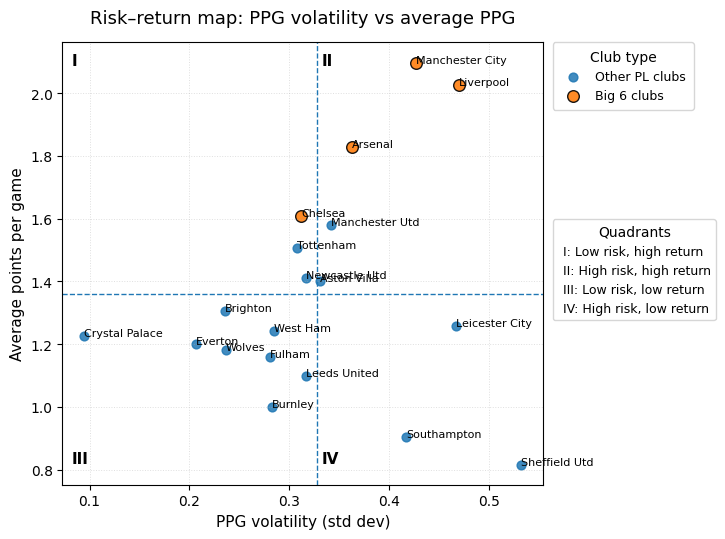

In [ ]:
from matplotlib.lines import Line2D

if "ppg_std" in core_df.columns:
    fig, ax = plt.subplots(figsize=(9.5, 5.5))

    x = core_df["ppg_std"]
    y = core_df["ppg"]
    labels = core_df["club"]

    big6_mask = core_df["club"].isin(BIG6)

    other_pts = ax.scatter(
        x[~big6_mask],
        y[~big6_mask],
        s=40,
        alpha=0.85,
        label="Other PL clubs",
    )

    big6_pts = ax.scatter(
        x[big6_mask],
        y[big6_mask],
        s=70,
        edgecolor="black",
        linewidth=1,
        alpha=0.9,
        label="Big 6 clubs",
    )

    x_ref = x.mean()
    y_ref = y.mean()
    ax.axvline(x_ref, linestyle="--", linewidth=1)
    ax.axhline(y_ref, linestyle="--", linewidth=1)

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    ax.text(
        x_min + 0.02 * (x_max - x_min),
        y_max - 0.05 * (y_max - y_min),
        "I",
        fontsize=11,
        fontweight="bold",
    )  # Low risk, high return

    ax.text(
        x_ref + 0.02 * (x_max - x_ref),
        y_max - 0.05 * (y_max - y_min),
        "II",
        fontsize=11,
        fontweight="bold",
    )  # High risk, high return

    ax.text(
        x_min + 0.02 * (x_max - x_min),
        y_min + 0.05 * (y_max - y_min),
        "III",
        fontsize=11,
        fontweight="bold",
    )  # Low risk, low return

    ax.text(
        x_ref + 0.02 * (x_max - x_ref),
        y_min + 0.05 * (y_max - y_min),
        "IV",
        fontsize=11,
        fontweight="bold",
    )  # High risk, low return

    for i, club in enumerate(labels):
        jitter_x = (0.006 * (x_max - x_min)) * ((i % 3) - 1)
        jitter_y = (0.012 * (y_max - y_min)) * (((i // 3) % 3) - 1)
        ax.annotate(
            club,
            (x.iloc[i], y.iloc[i]),
            xytext=(jitter_x, jitter_y),
            textcoords="offset points",
            fontsize=8,
        )

    ax.set_title("Risk–return map: PPG volatility vs average PPG", fontsize=13, pad=14)
    ax.set_xlabel("PPG volatility (std dev)", fontsize=11)
    ax.set_ylabel("Average points per game", fontsize=11)
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.4)

    club_handles = [other_pts, big6_pts]
    club_labels = ["Other PL clubs", "Big 6 clubs"]

    legend_clubs = ax.legend(
        club_handles,
        club_labels,
        title="Club type",
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),   # top-right outside the axes
        borderaxespad=0.0,
        borderpad=0.6,                # tighter padding inside the box
        fontsize=9,
        title_fontsize=10,
        frameon=True,
    )
    ax.add_artist(legend_clubs)       

    quadrant_handles = [
        Line2D([], [], linestyle="none", marker="", label="I: Low risk, high return"),
        Line2D([], [], linestyle="none", marker="", label="II: High risk, high return"),
        Line2D([], [], linestyle="none", marker="", label="III: Low risk, low return"),
        Line2D([], [], linestyle="none", marker="", label="IV: High risk, low return"),
    ]

    legend_quadrants = ax.legend(
        handles=quadrant_handles,
        title="Quadrants",
        loc="upper left",
        bbox_to_anchor=(1.02, 0.6),   
        borderaxespad=0.0,
        borderpad=0.4,
        handlelength=0,               
        handletextpad=0.4,
        fontsize=9,
        title_fontsize=10,
        frameon=True,
    )

    
    plt.tight_layout(rect=(0, 0, 0.78, 1))
    plt.show()

else:
    print("No 'ppg_std' column found – skipping risk–return plot.")


### Interpretation – Risk–return map: PPG volatility vs average PPG

- **Axes & quadrants**
  - X-axis = **PPG volatility (std dev)** over 2019–2025 → a proxy for **risk / inconsistency**.
  - Y-axis = **average points per game** → a proxy for **return / performance**.
  - The dashed vertical and horizontal lines mark the **league-wide averages**, splitting clubs into four “risk–return” archetypes.

- **High risk / high return (top-right)**
  - **Manchester City and Liverpool** sit clearly in this quadrant: they combine **very high average PPG** with **above-average volatility**.
  - These clubs sustain elite performance but accept large swings from season to season (e.g., title charges vs occasional blips).

- **Low risk / high return (top-left)**
  - Very few clubs live here. Most higher-performing teams also take on decent volatility.
  - The map suggests there are **almost no true “steady over-achievers”**; consistent quality without risk is rare in the modern PL.

- **Low risk / low return (bottom-left)**
  - Clubs such as **Crystal Palace, Wolves, Everton, Burnley, Fulham, Leeds** cluster around here.
  - They deliver **mid-table PPG with relatively modest volatility** – essentially “steady but unspectacular”.
  - This matches the intuition of these sides as reliable survivors rather than boom-or-bust projects.

- **High risk / low return (bottom-right)**
  - **Southampton and Sheffield United** are clear examples: they exhibit **high volatility but poor average PPG**.
  - These clubs take on a lot of performance risk (big swings season to season) **without getting the points to justify it**, often flirting with relegation.

- **Overall takeaway**
  - Big-narrative clubs (especially City and Liverpool) accept more volatility but are compensated with **very high returns**.
  - Many smaller clubs cluster in the **low-risk, low-return** space, suggesting their strategies (spend, squad churn, managerial changes) yield stability more than upside.
  - From a “portfolio” perspective, if you want **guaranteed excitement and upside**, you back City/Liverpool; if you want **safety**, you end up with Palace/Wolves-type profiles – but you rarely get both stability **and** top-tier results.


---

### Club-level regressions: performance vs networks and money

In this section we run simple OLS regressions at the **club level** (one row per club) to quantify how much **media centrality** and **money** explain on-pitch performance.

We use the aggregated club panel:

- Data source: `outputs/club_analysis_panel_2016_2022.csv` → `analysis_df`
- Grain: one row per club (27 clubs)
- Key variables:
  - **Performance**
    - `points_per_game` – average points per game across 2016–2022
  - **Network / hype**
    - `press_strength_norm` – normalized centrality in the press co-occurrence network
    - `reddit_strength_norm` – normalized centrality in the Reddit co-occurrence network
  - **Money**
    - `net_spend_eur_m` – net transfer spend (spend − income), in € millions

We estimate the following models:

- **Model A (Hype only)**  
  `points_per_game ~ press_strength_norm`

- **Model B (Money only, baseline)**  
  `points_per_game ~ net_spend_eur_m`

- **Model C (Core model: Hype + Money)**  
  `points_per_game ~ press_strength_norm + net_spend_eur_m`

- **Model D (Press + Reddit + Money)**  
  `points_per_game ~ press_strength_norm + reddit_strength_norm + net_spend_eur_m`

Interpretation goals:

- Compare **R²** of money-only vs. networks+money models.
- Check whether **press centrality remains significant** after controlling for net spend.
- See whether **Reddit centrality adds additional signal** once press + money are included.


In [ ]:
import statsmodels.formula.api as smf


reg_df = analysis_df.dropna(
    subset=[
        "points_per_game",
        "press_strength_norm",
        "reddit_strength_norm",
        "net_spend_eur_m",
    ]
).copy()

print("N club-seasons in regression sample:", reg_df.shape[0])
display(
    reg_df[
        ["club", "season_label", "points_per_game",
         "press_strength_norm", "reddit_strength_norm", "net_spend_eur_m"]
    ]
)


N club-seasons in regression sample: 118


,club,season_label,points_per_game,press_strength_norm,reddit_strength_norm,net_spend_eur_m
0,AFC Bournemouth,19/20,0.894737,0.251162,0.111111,223.585
1,AFC Bournemouth,22/23,1.026316,0.251162,0.111111,223.585
2,AFC Bournemouth,23/24,1.263158,0.251162,0.111111,223.585
3,AFC Bournemouth,24/25,1.473684,0.251162,0.111111,223.585
4,AFC Bournemouth,25/26,0.473684,0.251162,0.111111,223.585
...,...,...,...,...,...,...
113,Wolverhampton Wanderers,21/22,1.342105,0.181019,0.031250,311.187
114,Wolverhampton Wanderers,22/23,1.078947,0.181019,0.031250,311.187
115,Wolverhampton Wanderers,23/24,1.210526,0.181019,0.031250,311.187
116,Wolverhampton Wanderers,24/25,1.105263,0.181019,0.031250,311.187


### Model A: Performance ~ Press Centrality

**What this model does**

- Uses **season-level club data** where both performance and press centrality are observed.
- Dependent variable:  
  - `points_per_game` = league performance (PPG) for a given club-season.
- Predictor:
  - `press_strength_norm` = normalized centrality of the club in the **press network** (Guardian + Independent co-occurrence graph).

In [54]:
print("=== Model A: points_per_game ~ press_strength_norm ===")
print("Formula: points_per_game ~ press_strength_norm\n")

mA = smf.ols(
    formula="points_per_game ~ press_strength_norm",
    data=reg_df,
).fit()

print(mA.summary())


=== Model A: points_per_game ~ press_strength_norm ===
Formula: points_per_game ~ press_strength_norm

                            OLS Regression Results                            
Dep. Variable:        points_per_game   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     27.98
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           5.86e-07
Time:                        21:41:33   Log-Likelihood:                -90.318
No. Observations:                 118   AIC:                             184.6
Df Residuals:                     116   BIC:                             190.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------

### Interpretation – Model A: `points_per_game ~ press_strength_norm`

- **Direction & magnitude:** The coefficient on `press_strength_norm` is about **+1.00**, meaning that moving a club from **0 to 1** on press centrality is associated with roughly **+1.0 points per game** (a massive shift, roughly the difference between relegation form and title-contender form).  
- **Significance:** The coefficient is **highly significant** (t ≈ 5.29, p < 0.001), so there is a strong statistical relationship between press centrality and points per game in this sample.  
- **Fit:** The model explains about **19% of the variance** in PPG (R² ≈ 0.19). That’s meaningful for a one-variable model, but still leaves most of the variation to other factors (squad quality, tactics, injuries, etc.).  
- **Takeaway:** Even without controlling for money or other variables, **more central clubs in the press network tend to perform better on the pitch**, but press centrality is clearly not the whole story.


---

### Model B: Performance ~ Net Transfer Spend

**What this model does**

- Same club-season sample as Model A, but now we only use **money** as a predictor.
- Dependent variable:
  - `points_per_game`
- Predictor:
  - `net_spend_eur_m` = net transfer spending (spend – income) in millions of euros over the 2016–2022 window.

In [55]:
print("=== Model B: points_per_game ~ net_spend_eur_m ===")
print("Formula: points_per_game ~ net_spend_eur_m\n")

mB = smf.ols(
    formula="points_per_game ~ net_spend_eur_m",
    data=reg_df,
).fit()

print(mB.summary())


=== Model B: points_per_game ~ net_spend_eur_m ===
Formula: points_per_game ~ net_spend_eur_m

                            OLS Regression Results                            
Dep. Variable:        points_per_game   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     19.79
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           1.99e-05
Time:                        21:41:36   Log-Likelihood:                -93.770
No. Observations:                 118   AIC:                             191.5
Df Residuals:                     116   BIC:                             197.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

### Interpretation – Model B: `points_per_game ~ net_spend_eur_m`

- **Direction & magnitude:** The coefficient on `net_spend_eur_m` is positive and small in absolute value (~0.0009), but remember this is per **€1 million**. That implies that an extra **€100m of net spend** is associated with about **+0.09 points per game** on average.  
- **Significance:** The spending effect is **statistically significant** (t ≈ 4.45, p < 0.001), so there is a clear positive association between spending and performance.  
- **Fit:** This model explains about **15% of the variance** in PPG (R² ≈ 0.15), slightly less than the press-only model.  
- **Takeaway:** **Money matters**: higher net spend is linked to better league performance, but—like press centrality—it still leaves most of the performance variation unexplained.


---


### Model C: Performance ~ Press Centrality + Net Spend

**What this model does**

- Combines **narrative position in the press network** with **financial firepower**.
- Dependent variable:
  - `points_per_game`
- Predictors:
  - `press_strength_norm`
  - `net_spend_eur_m`

In [56]:
print("=== Model C: points_per_game ~ press_strength_norm + net_spend_eur_m ===")
print("Formula: points_per_game ~ press_strength_norm + net_spend_eur_m\n")

mC = smf.ols(
    formula="points_per_game ~ press_strength_norm + net_spend_eur_m",
    data=reg_df,
).fit()

print(mC.summary())

=== Model C: points_per_game ~ press_strength_norm + net_spend_eur_m ===
Formula: points_per_game ~ press_strength_norm + net_spend_eur_m

                            OLS Regression Results                            
Dep. Variable:        points_per_game   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     15.88
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           8.11e-07
Time:                        21:41:38   Log-Likelihood:                -88.673
No. Observations:                 118   AIC:                             183.3
Df Residuals:                     115   BIC:                             191.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0

### Interpretation – Model C:  
`points_per_game ~ press_strength_norm + net_spend_eur_m`

- **Joint story:** When we include **both** press centrality and net spend, the model’s R² rises to about **0.22**, meaning the pair together explain roughly **21–22%** of the variation in PPG.  
- **Press effect (conditional on money):**  
  - The coefficient on `press_strength_norm` drops from ~1.00 (Model A) to about **0.75**, but remains **statistically significant** (p ≈ 0.002).  
  - This means even **after controlling for net spend**, clubs that are more central in the press still tend to have higher points per game.  
- **Money effect (conditional on press):**  
  - The coefficient on `net_spend_eur_m` remains **positive** but is now only **marginally significant** (p ≈ 0.07).  
  - This suggests that part of what “money” captured in Model B may overlap with what press centrality is capturing (big, successful clubs tend to both spend more and dominate headlines).  
- **Takeaway:** **Press centrality adds explanatory power beyond transfer spending.** Hype/attention seems to carry signal about performance that is not fully reducible to “they just spend more.”


---


### Model D: Performance ~ Press + Reddit + Net Spend

**What this model does**

- Adds **Reddit centrality** as a second narrative signal alongside press and money.
- Dependent variable:
  - `points_per_game`
- Predictors:
  - `press_strength_norm`
  - `reddit_strength_norm`
  - `net_spend_eur_m`

**Key questions this model answers**

1. Does Reddit centrality add any **independent** signal once we already know:
   - how big a club is in the press network, and  
   - how much they spend?
2. Are Reddit and press essentially the **same “big club” signal**, or do they play slightly different roles?

In [57]:
print("=== Model D: points_per_game ~ press_strength_norm + reddit_strength_norm + net_spend_eur_m ===")
print("Formula: points_per_game ~ press_strength_norm + reddit_strength_norm + net_spend_eur_m\n")

mD = smf.ols(
    formula="points_per_game ~ press_strength_norm + reddit_strength_norm + net_spend_eur_m",
    data=reg_df,
).fit()

print(mD.summary())

=== Model D: points_per_game ~ press_strength_norm + reddit_strength_norm + net_spend_eur_m ===
Formula: points_per_game ~ press_strength_norm + reddit_strength_norm + net_spend_eur_m

                            OLS Regression Results                            
Dep. Variable:        points_per_game   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     10.90
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           2.39e-06
Time:                        21:41:41   Log-Likelihood:                -88.190
No. Observations:                 118   AIC:                             184.4
Df Residuals:                     114   BIC:                             195.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         

### Interpretation – Model D:  
`points_per_game ~ press_strength_norm + reddit_strength_norm + net_spend_eur_m`

- **Overall fit:** Adding Reddit centrality nudges R² up only slightly to about **0.22–0.23**. The improvement over Model C is minimal.  
- **Press vs Reddit:**  
  - Both `press_strength_norm` and `reddit_strength_norm` become **individually non-significant** once they are in the model together with net spend (p-values > 0.30).  
  - This suggests **strong collinearity**: press and Reddit centrality are capturing very similar “big club / attention” signal, so the model struggles to disentangle their separate effects.  
- **Net spend:**  
  - `net_spend_eur_m` remains **positive** and marginally significant (p ≈ 0.06), similar to Model C.  
- **Takeaway:** From a parsimony perspective, **Model C is the cleaner summary**: Reddit centrality does not add clear incremental explanatory power once press + money are included. Reddit behaves more like **another reflection of the same attention structure** rather than a distinct predictor.


---


### Model E: Volatility (Risk) ~ Press Centrality

**What this model does**

- Uses the **risk/return panel** (club-level summary over 2019–2025).
- Dependent variable:
  - `ppg_std` = **standard deviation of points per game across seasons**, i.e. how “bouncy” a club’s performance is over time.
- Predictor:
  - `press_strength_norm` = normalized press centrality (same scale as before).

**Role in the overall narrative**

- Complements Models A–D:
  - A–D focus on **average performance** and how networks/money relate to PPG.
  - Model E looks at the **risk side of the trade-off**, situating clubs on a “risk–return” map:  
    *How central, how good, and how wild are their seasons?*


In [ ]:
# === Model E: Risk/volatility vs press centrality ===


risk_path = BASE_DIR / "outputs" / "club_risk_return_panel_2019_2025.csv"
risk_panel = pd.read_csv(risk_path)

print("risk_panel shape:", risk_panel.shape)
print("risk_panel columns:", risk_panel.columns.tolist())
display(risk_panel.head())


core_risk_df = risk_panel.rename(columns={"avg_ppg": "ppg"}).copy()


risk_df = core_risk_df.dropna(subset=["ppg_std", "press_strength_norm"]).copy()

print("\nN clubs in Model E sample:", risk_df.shape[0])
display(risk_df[["club", "ppg", "ppg_std", "press_strength_norm"]])


print("\n=== Model E: ppg_std ~ press_strength_norm ===")
print("Formula: ppg_std ~ press_strength_norm\n")

mE = smf.ols("ppg_std ~ press_strength_norm", data=risk_df).fit()
print(mE.summary())


risk_panel shape: (19, 11)
risk_panel columns: ['club', 'seasons_played', 'avg_ppg', 'ppg_std', 'worst_ppg', 'best_ppg', 'avg_attendance', 'press_strength_norm', 'reddit_strength_norm', 'net_spend_eur_m', 'revenue']


,club,seasons_played,avg_ppg,ppg_std,worst_ppg,best_ppg,avg_attendance,press_strength_norm,reddit_strength_norm,net_spend_eur_m,revenue
0,Arsenal,7,1.827068,0.362374,1.394737,2.342105,43835.066058,0.544904,0.428571,NaN,435000.0
1,Aston Villa,7,1.402256,0.331033,0.921053,1.789474,36307.651534,0.427374,0.024845,0.000003,236000.0
2,Brighton,7,1.304511,0.235306,1.078947,1.631579,31891.852255,NaN,NaN,NaN,NaN
3,Burnley,5,1.000000,0.282818,0.631579,1.421053,25861.241331,0.310778,0.074534,NaN,135200.0
4,Chelsea,7,1.609023,0.311902,1.157895,1.947368,35345.702230,0.927898,1.000000,NaN,586000.0



N clubs in Model E sample: 11


,club,ppg,ppg_std,press_strength_norm
0,Arsenal,1.827068,0.362374,0.544904
1,Aston Villa,1.402256,0.331033,0.427374
3,Burnley,1.000000,0.282818,0.310778
4,Chelsea,1.609023,0.311902,0.927898
6,Everton,1.199248,0.206573,0.634637
7,Fulham,1.157895,0.280359,0.310725
8,Leeds United,1.098684,0.316793,0.254482
9,Leicester City,1.257895,0.467207,0.404567
10,Liverpool,2.026316,0.469278,1.000000
11,Manchester City,2.097744,0.426693,0.708843



=== Model E: ppg_std ~ press_strength_norm ===
Formula: ppg_std ~ press_strength_norm

                            OLS Regression Results                            
Dep. Variable:                ppg_std   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.7087
Date:                Sat, 06 Dec 2025   Prob (F-statistic):              0.422
Time:                        21:41:44   Log-Likelihood:                 12.521
No. Observations:                  11   AIC:                            -21.04
Df Residuals:                       9   BIC:                            -20.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

c:\Users\dshog\healthcare_env\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


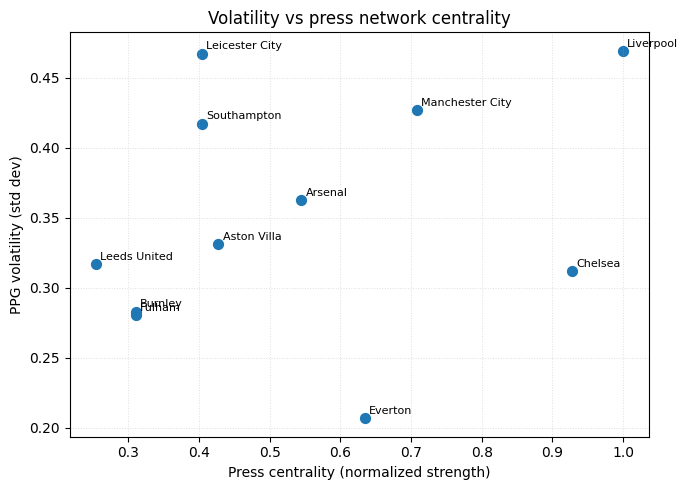

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))


plt.scatter(risk_df["press_strength_norm"], risk_df["ppg_std"], s=50)


for _, row in risk_df.iterrows():
    plt.annotate(
        row["club"],
        (row["press_strength_norm"], row["ppg_std"]),
        xytext=(3, 3),                # offset in points
        textcoords="offset points",
        fontsize=8,
    )

plt.xlabel("Press centrality (normalized strength)")
plt.ylabel("PPG volatility (std dev)")
plt.title("Volatility vs press network centrality")
plt.grid(True, linestyle=":", linewidth=0.7, alpha=0.4)
plt.tight_layout()
plt.show()


### Interpretation – Model E: `ppg_std ~ press_strength_norm`

- **Outcome:** Here the dependent variable is **PPG volatility** (`ppg_std`) across seasons, rather than average performance.  
- **Effect size & significance:** The coefficient on `press_strength_norm` is small (~0.09) and **not statistically significant** (p ≈ 0.42).  
- **Fit:** The model R² is very low (~0.07) and the adjusted R² is actually **negative**, indicating that the linear model does **not** meaningfully explain volatility.  
- **Sample size caveat:** This regression is based on a **small number of clubs/seasons (N ≈ 11)**, so results are noisy and should be read cautiously.  
- **Takeaway:** With the current data, **press centrality does not appear to be a reliable predictor of how “risky” or volatile a club’s performance is**. High-attention clubs are not systematically more or less volatile in their season-to-season PPG.


---


## Club archetypes via clustering

So far we’ve looked at bivariate relationships and regressions.  
Now we ask a different question:

> **Are there distinct “types” of clubs once we jointly consider hype (centrality), money (net spend), and performance (PPG)?**

To explore this, we:

- Select a compact feature set:
  - `press_strength_norm` (press centrality)
  - `reddit_strength_norm` (Reddit centrality)
  - `net_spend_eur_m` (total net transfer spend)
  - `points_per_game` (average league performance)
- Standardize these variables.
- Run a simple **K-means clustering** with `k = 3` clusters.
- Visualize the resulting clusters in centrality–performance space.

The goal is not to find a “true” taxonomy of clubs, but to see whether intuitive archetypes emerge:

- **Big-money, big-attention contenders**
- **Low-spend overperformers**
- **Low-attention, low-spend strugglers**, etc.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


cluster_cols = [
    "press_strength_norm",
    "reddit_strength_norm",
    "net_spend_eur_m",
    "points_per_game",
]

cluster_df = analysis_df.dropna(subset=cluster_cols + ["club"]).copy()
print("N clubs in clustering sample:", cluster_df.shape[0])

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(cluster_df[cluster_cols].astype(float))

# K-means with 3 clusters 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

cluster_df["cluster"] = cluster_labels


analysis_df["cluster"] = np.nan
for club, cl in zip(cluster_df["club"], cluster_df["cluster"]):
    analysis_df.loc[analysis_df["club"] == club, "cluster"] = cl


cluster_summary = (
    cluster_df[["cluster"] + cluster_cols]
    .groupby("cluster")
    .mean()
    .round(3)
)

print("Cluster summary (mean feature values by cluster):")
display(cluster_summary)

print("\nCluster membership:")
display(
    cluster_df[["club", "cluster"]]
    .sort_values(["cluster", "club"])
)


N clubs in clustering sample: 118
Cluster summary (mean feature values by cluster):


,press_strength_norm,reddit_strength_norm,net_spend_eur_m,points_per_game
cluster,,,,
0,0.331,0.140,207.067,1.055
1,0.641,0.384,728.300,1.729
2,0.930,0.855,508.401,1.609



Cluster membership:


,club,cluster
0,AFC Bournemouth,0
1,AFC Bournemouth,0
2,AFC Bournemouth,0
3,AFC Bournemouth,0
4,AFC Bournemouth,0
...,...,...
97,Tottenham Hotspur,2
98,Tottenham Hotspur,2
99,Tottenham Hotspur,2
100,Tottenham Hotspur,2


Cluster base (one row per club): (21, 5)


,club,press_strength_norm,reddit_strength_norm,net_spend_eur_m,points_per_game
0,AFC Bournemouth,0.251162,0.111111,223.585,1.026316
1,Arsenal,0.517891,0.472222,643.130,1.721805
2,Aston Villa,0.400528,0.097222,304.040,1.296992
3,Brentford,0.253130,0.031250,83.600,1.121053
4,Brighton & Hove Albion,0.422614,0.388889,123.800,1.199248


Cluster summary (means by cluster):


,press_strength_norm,reddit_strength_norm,net_spend_eur_m,points_per_game
cluster,,,,
0,0.31,0.12,183.45,1.00
1,0.64,0.38,728.30,1.73
2,0.93,0.86,508.40,1.61


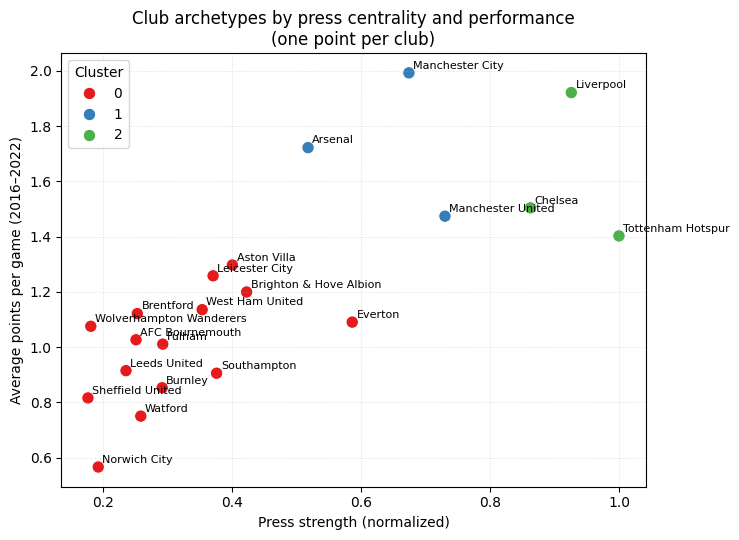

In [ ]:


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns



cluster_cols = [
    "press_strength_norm",
    "reddit_strength_norm",
    "net_spend_eur_m",
    "points_per_game",
]

tmp = analysis_df.dropna(subset=cluster_cols + ["club"]).copy()


cluster_df = (
    tmp.groupby("club", as_index=False)
       .agg({col: "mean" for col in cluster_cols})
)

print("Cluster base (one row per club):", cluster_df.shape)
display(cluster_df.head())


scaler = StandardScaler()
X = scaler.fit_transform(cluster_df[cluster_cols])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_df["cluster"] = kmeans.fit_predict(X)

cluster_summary = (
    cluster_df.groupby("cluster")[cluster_cols]
    .mean()
    .round(2)
)
print("Cluster summary (means by cluster):")
display(cluster_summary)

fig, ax = plt.subplots(figsize=(7.5, 5.5))

sns.scatterplot(
    data=cluster_df,
    x="press_strength_norm",
    y="points_per_game",
    hue="cluster",
    palette="Set1",
    s=80,
    ax=ax,
)

for _, row in cluster_df.iterrows():
    ax.annotate(
        row["club"],
        (row["press_strength_norm"], row["points_per_game"]),
        xytext=(3, 3),
        textcoords="offset points",
        fontsize=8,
    )

ax.set_xlabel("Press strength (normalized)")
ax.set_ylabel("Average points per game (2016–2022)")
ax.set_title("Club archetypes by press centrality and performance\n(one point per club)")
ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.4)
ax.legend(title="Cluster", loc="best")

plt.tight_layout()
plt.show()


### Interpretation: Club archetypes by press centrality and performance  
*(one point per club, averages 2016–2022)*

**Axes recap**

- **X-axis – Press strength (normalized)**  
  - 0 = barely present in the press-based transfer network  
  - 1 = constantly in transfer headlines and rumours  

- **Y-axis – Average points per game (2016–2022)**  
  - Higher = stronger on-pitch performance over the sample

The K-Means clustering splits clubs into three broad archetypes:

#### Cluster 0 – “Background battlers” (red)

- **Location on plot:**  
  - Left side (low press_strength_norm)  
  - Mostly below or around ~1.2 PPG  

- **Typical clubs:**  
  - Norwich, Watford, Burnley, Sheffield United, Wolves, Leeds, Brentford, Bournemouth, Brighton (on the border), etc.

- **Story:**  
  - These clubs get relatively **little transfer-rumour coverage** compared to the rest of the league.  
  - On the pitch, they tend to be **mid-table to relegation-battle** sides over 2016–2022.  
  - You can read this cluster as **“low narrative capital, modest sporting returns”** – clubs whose stories rarely dominate back pages and whose performance is usually about survival or consolidation rather than title races.


#### Cluster 1 – “Efficient contenders” (blue)

- **Location on plot:**  
  - Middle of the x-axis (moderate press centrality)  
  - Clearly **above-average PPG** (around 1.5–2.0+)  

- **Typical clubs:**  
  - Manchester City, Arsenal, Manchester United, Everton (borderline), maybe 1–2 other solid sides depending on the exact clustering.

- **Story:**  
  - These clubs combine **strong on-pitch performance** with **only moderate press centrality** in the transfer-rumour network (at least relative to the true “headline monsters” in Cluster 2).  
  - You can think of them as **“sport-led brands”** – teams that rack up points, win titles or push for them, but don’t necessarily dominate every transfer saga.  
  - For City in particular, this reinforces the idea that **performance can be elite even if transfer gossip volume isn’t absolutely maximal**.


#### Cluster 2 – “Headline clubs” (green)

- **Location on plot:**  
  - Far right (very high press_strength_norm)  
  - Mixed but generally solid PPG (roughly ~1.4–2.0)  

- **Typical clubs:**  
  - Liverpool, Chelsea, Tottenham Hotspur (and possibly other “Big 6” brands depending on cluster assignment).

- **Story:**  
  - These are the **true narrative hubs**: clubs that sit at the **centre of transfer rumours and media attention** year in, year out.  
  - Liverpool and Chelsea pair **high press centrality with strong PPG**, meaning the hype largely matches on-pitch outcomes.  
  - **Tottenham** is especially interesting: extremely high press centrality but a **lower average PPG** than Liverpool/City, making them a classic **“high-attention, mixed-return”** club.  
  - Overall, Cluster 2 is **“brand-driven giants”** – clubs where media attention is almost guaranteed regardless of whether a given season is brilliant or disappointing.


### Takeaways

- **Centrality and success are related but not identical.**  
  - Higher press centrality is loosely associated with better performance, but there are **clear mismatches** (e.g., Spurs’ hype vs. points).

- **Narrative inequality is real.**  
  - A handful of clubs (Cluster 2) dominate transfer narratives, while most of the league lives in Cluster 0’s low-attention space.

- **Cluster 1 shows that you can be elite without max hype.**  
  - Clubs like Manchester City and (in this sample) Arsenal prove that **performance can outstrip narrative volume**, at least in transfer-rumour terms.


---

## Season-by-season performance trends

The regressions and clustering use **club-level aggregates** (2016–2022 averages).  
To add temporal texture, we look at **season-by-season points per game** using the FBref fixture data.

Steps:

1. Load `fbref_pl_fixtures_2019_2025.csv`.
2. Convert each fixture into two rows (home/away perspective).
3. Compute PPG by `club × season`.
4. Plot PPG trajectories for a few illustrative clubs:
   - Traditional “Big 6” contenders
   - Emerging or volatile sides (e.g., Brighton, Brentford).


In [64]:
fixtures_path = BASE_DIR / "Fixture data 2019-2025" / "fbref_pl_fixtures_2019_2025.csv"
fixtures = pd.read_csv(fixtures_path)

print("fixtures shape:", fixtures.shape)
print("fixture columns:", fixtures.columns.tolist())
display(fixtures.head())

def build_season_ppg(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute season-by-season points per game for each club.

    Assumes columns:
      - 'season': season label (e.g., '2019-20')
      - 'home', 'away': club names
      - 'home_goals', 'away_goals': final scores
    """
    # Home perspective
    home = df[["season", "home", "home_goals", "away_goals"]].copy()
    home["club"] = home["home"]
    home["gf"] = home["home_goals"]
    home["ga"] = home["away_goals"]

    # Away perspective
    away = df[["season", "away", "home_goals", "away_goals"]].copy()
    away["club"] = away["away"]
    away["gf"] = away["away_goals"]
    away["ga"] = away["home_goals"]

    both = pd.concat([home, away], ignore_index=True)

    # Points: 3 win, 1 draw, 0 loss
    both["points"] = np.where(
        both["gf"] > both["ga"], 3,
        np.where(both["gf"] == both["ga"], 1, 0)
    )

    summary = (
        both.groupby(["club", "season"], as_index=False)
        .agg(
            matches=("points", "size"),
            total_points=("points", "sum"),
            goals_for=("gf", "sum"),
            goals_against=("ga", "sum"),
        )
    )
    summary["points_per_game"] = summary["total_points"] / summary["matches"]
    return summary

club_season_perf = build_season_ppg(fixtures)
print("club_season_perf shape:", club_season_perf.shape)
display(club_season_perf.head())


fixtures shape: (2660, 9)
fixture columns: ['date', 'home', 'away', 'home_goals', 'away_goals', 'attendance', 'venue', 'season', 'game_id']


,date,home,away,home_goals,away_goals,attendance,venue,season,game_id
0,2019-08-09,Liverpool,Norwich City,4.0,1.0,53333.0,Anfield,1920,928467bd
1,2019-08-10,Bournemouth,Sheffield Utd,1.0,1.0,10714.0,Vitality Stadium,1920,d402cacd
2,2019-08-10,Burnley,Southampton,3.0,0.0,19784.0,Turf Moor,1920,34b99058
3,2019-08-10,Crystal Palace,Everton,0.0,0.0,25151.0,Selhurst Park,1920,a802f51e
4,2019-08-10,Tottenham,Aston Villa,3.0,1.0,60407.0,Tottenham Hotspur Stadium,1920,404ee5d3


club_season_perf shape: (140, 7)


,club,season,matches,total_points,goals_for,goals_against,points_per_game
0,Arsenal,1920,38,56,56.0,48.0,1.473684
1,Arsenal,2021,38,61,55.0,39.0,1.605263
2,Arsenal,2122,38,69,61.0,48.0,1.815789
3,Arsenal,2223,38,84,88.0,43.0,2.210526
4,Arsenal,2324,38,89,91.0,29.0,2.342105


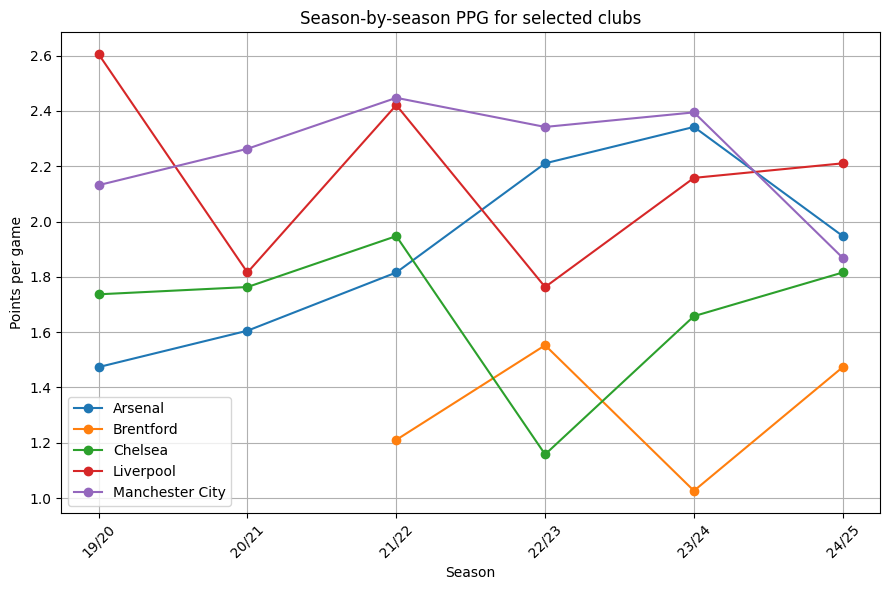

In [ ]:
clubs_to_plot = [
    "Liverpool",
    "Manchester City",
    "Arsenal",
    "Chelsea",
    "Brighton & Hove Albion",
    "Brentford",
]

subset = club_season_perf[club_season_perf["club"].isin(clubs_to_plot)].copy()

def make_season_label(val):
    s = str(val)
    if "/" in s:
        return s
    if "-" in s:
        start, end = s.split("-", 1)
        start = start.strip()
        end = end.strip()
        return f"{start[-2:]}/{end[-2:]}"
    if len(s) == 4 and s.isdigit():
        return f"{s[:2]}/{s[2:]}"
    return s

subset["season_label"] = subset["season"].apply(make_season_label)

subset = subset[subset["season_label"] != "25/26"]

season_order = ["19/20", "20/21", "21/22", "22/23", "23/24", "24/25"]
subset = subset[subset["season_label"].isin(season_order)].copy()
subset["season_label"] = pd.Categorical(
    subset["season_label"],
    categories=season_order,
    ordered=True,
)

plt.figure(figsize=(9, 6))

for club, sub in subset.groupby("club"):
    sub = sub.sort_values("season_label")
    plt.plot(
        sub["season_label"].astype(str),
        sub["points_per_game"],
        marker="o",
        label=club,
    )

plt.xlabel("Season")
plt.ylabel("Points per game")
plt.title("Season-by-season PPG for selected clubs")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Interpretation – Season-by-season PPG for selected clubs (2019/20–2024/25)

Overall, the chart shows **five clubs with very different trajectories** over the last six seasons.  
Remember: the 24/25 season is still in progress, so the right-most values are snapshots, not final totals.

---

#### Big picture

- **Manchester City and Liverpool** spend the whole period in the “elite” band (around 2+ PPG), but:
  - City are **more consistently high** and stable.
  - Liverpool show a **sharp dip in 20/21 and 22/23**, then recover again.
- **Arsenal** move from “good” (mid-table European spots) to **title-contender level** by 22/23 and 23/24.
- **Chelsea** slide from solid top-4 levels to a clear **downturn around 22/23**, then partially recover.
- **Brentford** (only present from promotion onward) hover in the **mid-table band**, with some season-to-season volatility but no disaster years.

---

#### Club-by-club notes

**Arsenal**
- Start around **1.45–1.6 PPG (19/20–20/21)** → typical fringe top-4 / Europa form.
- Gradual improvement into **21/22**, then a big jump to **>2.2 PPG in 22/23 and 23/24**, i.e. genuine title-race pace.
- Slight pullback in **24/25** but still clearly above their early-period level.  
  ➜ Story: **steady rebuild → two seasons of title-level performance → small regression but still strong.**

**Brentford**
- Join the series later (promotion) with **solid mid-table PPG (~1.2–1.6)**.
- Peak around **22/23**, then drop back somewhat in 23/24 before improving again in 24/25.
- Never reach European-contender levels but also avoid relegation-level PPG.  
  ➜ Story: **successful promoted side that stabilizes in mid-table with some noise year-to-year.**

**Chelsea**
- Begin at **~1.75 PPG in 19/20**, rising close to **~1.95 in 21/22** (top-4 calibre).
- Collapse to roughly **1.15–1.2 PPG in 22/23** – that’s bottom-half / relegation-scrap territory for a club of their size.
- Recover in **23/24 and 24/25** to around **1.65–1.8 PPG**, but still below their early-period peak.  
  ➜ Story: **clear boom-and-bust: top-4 side → crisis season → partial recovery.**

**Liverpool**
- Open with an **elite 19/20 (≈2.6 PPG)**, title-winning pace.
- Sharp drop in **20/21**, then oscillate: down again in **22/23**, back up above **2.1 PPG** in 23/24 and stable in 24/25.
- Compared to City, more **volatile**, but their ceiling remains extremely high.  
  ➜ Story: **extreme peak, mid-cycle wobble, then retooling back toward title-challenger form.**

**Manchester City**
- Start already high (~2.15 PPG) and **climb to ~2.4–2.45 PPG in 21/22–22/23**.
- Very small fluctuations across the whole period; all seasons are **title-race or title-winning level**.
- Slight softening in 24/25 but still above ~1.9 PPG.  
  ➜ Story: **dominant and remarkably stable benchmark for elite performance.**

---

#### Cross-club comparison

- **Trend line**:
  - Arsenal’s line is the **steepest upward** over the six-season window.
  - Chelsea shows the **largest mid-period collapse** among this group.
- **Volatility**:
  - Liverpool and Chelsea are more **up-and-down**.
  - Manchester City and, to a lesser extent, Brentford are more **stable**.
- **Current snapshot (24/25)**:
  - City, Liverpool, and Arsenal remain in a **clear top tier**.
  - Chelsea sit in the **upper-mid table band**.
  - Brentford are in the **mid-table** range, still performing comfortably above relegation pace.
